# Credit Approval
There are many instant loan / instant credit mobile apps available in India. These app have to make quick decision if credit should be granted or denied. They recieve huge volume of applications daily, approval gets expensive soon which calls for automation. 

# Confidentiality
The data contains credit card applications. All attribute names and values have been changed to meaningless symbols to protect the confidentiality of the data.

# Data Credits
This data is provided by [UCI](http://archive.ics.uci.edu/ml/datasets/credit+approval), we'll download it from [OpenML](https://www.openml.org/d/29).

In [ ]:
!wget -q -O credit.csv https://www.openml.org/data/get_csv/29/dataset_29_credit-a.csv

# Look at data

In [1]:
import math
import time
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import warnings
from sklearn import set_config
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

In [2]:
def get_data():
    return pd.read_csv('./credit.csv', na_values='?')

data = get_data()

In [3]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [4]:
print("Null Columns\n")

def na_cols(data):
    count = data.isnull().sum()
    count = count[count > 0]

    prec = data.isnull().mean() * 100
    prec = prec[prec > 0]

    nas = pd.DataFrame(count, columns=['count'])
    nas['precentage'] = prec

    return nas

na_cols(data)

Null Columns



,count,precentage
A1,12,1.739130
A2,12,1.739130
A4,6,0.869565
A5,6,0.869565
A6,9,1.304348
A7,9,1.304348
A14,13,1.884058


In [5]:
print("Categorical Columns\n")

def get_cat_cols(data):
    return pd.DataFrame(data.select_dtypes(include=['object']).nunique(), columns=['num categories'])

get_cat_cols(data)

Categorical Columns



,num categories
A1,2
A4,3
A5,3
A6,14
A7,9
A9,2
A10,2
A12,2
A13,3
class,2


In [6]:
print("Numeric Columns\n")

data.select_dtypes(include=['int', 'float']).describe()

Numeric Columns



,A2,A3,A8,A11,A14,A15
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000


# EDA

In [7]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [8]:
def show_crosstab(data, col, ax=None):
    crosstab = pd.crosstab(index=data[col], 
                           columns=data['class'].map({'+': 'Approved', '-': 'Rejected'}),
                           normalize='columns')

    crosstab *= 100

    crosstab.plot(
        kind='bar',
        rot=0, 
        ax=ax,
        ylabel='Approval');

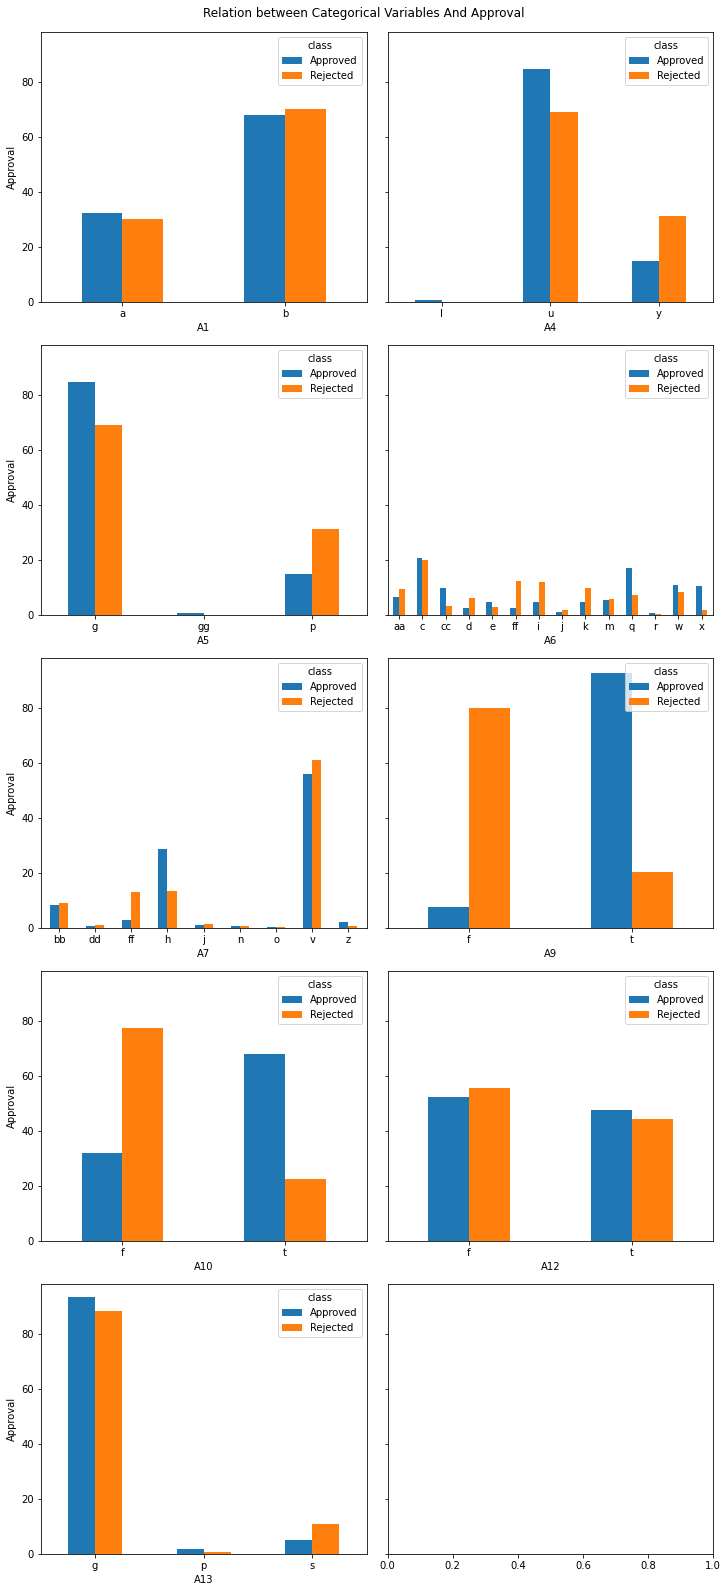

In [9]:
cols = data.select_dtypes(include=['object']).columns.values

cols = [col for col in cols if col != 'class']

fig, axs = plt.subplots(nrows=math.ceil(len(cols)/2), ncols=2, 
                      figsize=(10, int(5*len(cols)/2)),
                      sharey=True,
                      constrained_layout=True)

axs = axs.ravel()

for i, ax in enumerate(axs):
    if i < len(cols):
        show_crosstab(data, cols[i], ax=ax)

fig.suptitle("Relation between Categorical Variables And Approval")

plt.show()

* A9 Looks really strong feature
* A1, A12, A13 dont look helpful
* rest are somewhere in between

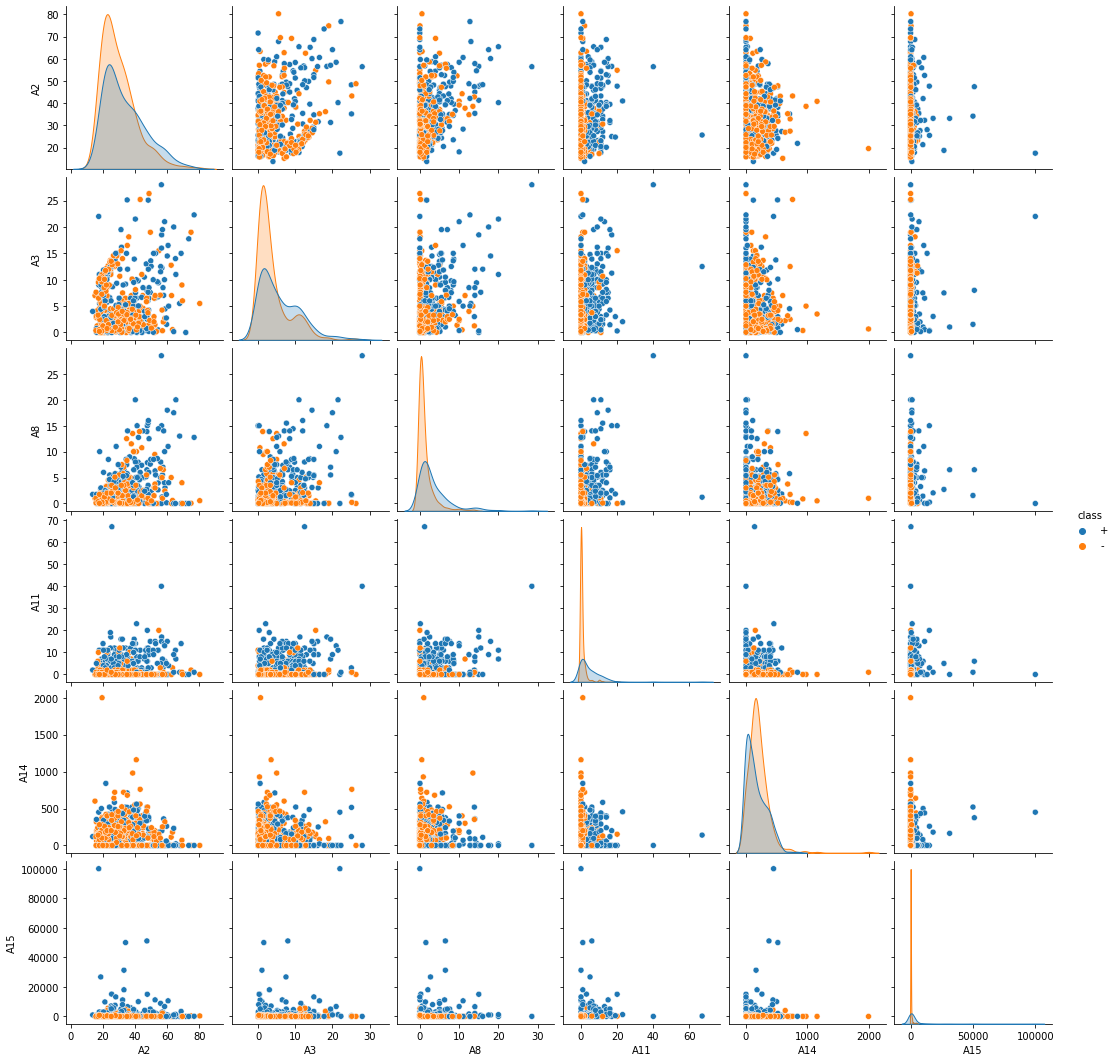

In [10]:
# relation between numeric and result
sns.pairplot(data=data, hue='class')

* no pair of numeric column is sufficient to seperate both classes
* A3 A8 A11 A15 can be useful to separate out most -ve(rejections)

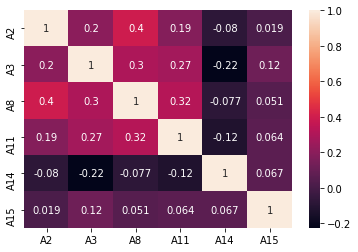

In [11]:
sns.heatmap(data.corr(), annot=True);

as most column pair has low correlation no features are redundant

# Column Preprocessing

**Encoding of categorical columns must be done on entire dataset**

* normalize numeric columns
* vectorize categorical columns

In [12]:
def build_categorical_transformers(data):
    """transformers for categorical columns
    """
    transforms = []

    # categorical columns
    cols = data.select_dtypes(include=['object', 'category', 'bool']).columns
    
    for col in cols:

        # list of categories
        categories = np.sort([v for v in data[col].unique() if not pd.isna(v)])
        
        # most frequest category
        most_frequent = data[col].value_counts()[:1].index.tolist()[0]

        # replace nan with most_frequent_category
        # and one hot encode data
        pipeline = Pipeline([
              (
                  f'imputer_{col}',
                  SimpleImputer(strategy='constant', fill_value=most_frequent),   
              ),
              (
                  f'encoder_{col}',
                  OneHotEncoder(
                    handle_unknown='ignore', 
                    categories=[categories],
                  )
              ),                
        ])
        transform = (f"categorical_{col}", pipeline, [col])
        transforms.append(transform)
    return transforms

def build_numeric_transformers():
    """transformers for numeric columns
    """
    num_selector = make_column_selector(dtype_include=['int', 'float'])
    return [('numeric',
         Pipeline([
             ('imputer', SimpleImputer()), 
             ('scaler', StandardScaler())
         ]), 
         num_selector)]

def build_column_transformer(data):
    """column transformer for preprocessing data
    """
    transformers = [
            *build_numeric_transformers(),
            *build_categorical_transformers(data)]

    return ColumnTransformer(transformers=transformers, remainder='drop')

In [13]:
# # uncomment to test if there are 46 columns with no null values
# ct = build_column_transformer(data.drop('class', axis=1))
# pd.DataFrame(ct.fit_transform(data.drop('class', axis=1))).isna().sum().value_counts()

# Build pipeline

In [14]:
x = data.drop('class', axis=1)
y = data['class'].map({'+': 1, '-': 0})

# must be done on entire data
column_transformer = build_column_transformer(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify=y)

In [15]:
pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('clf', RandomForestClassifier()),
])

In [ ]:
set_config(display='diagram')
pipeline

# Choosing Evaluation Metrics

* The Evaulation Metric chosen must align, with business objectives.

### Objective 1: Avoid Bad Credit
* If business wants to approve credit only if its sure that it wont turn bad we could chose precision or false positive rate as our metric.

### Objective 2: Customer Aquisition
* If business objective is customer aquisiton, we might grant credit even if we're not too sure if it will turn out to be bad, in this case we could use recall as our metric.

### Objective 3: Bit of both
* Acquiring new customers as well as preventing bad credit are important for business. Business wants some balance between these two. In this case we could use ROC-AUC or use f1 score as our metric.

### Chosen Objective: Objective 3: Bit of both
* We'll maximize AUC, and use ROC-AUC Curve.

# Grid Search

In [17]:
params = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 50, 90, 100, 120, 150],
        "clf__max_depth": [None, 3, 5, 7],
        "clf__min_samples_split": [2, 4],
        "clf__min_samples_leaf":[1, 2, 5],
        "clf__max_leaf_nodes": [2, 5, 10],
        "clf__max_features": ['auto', 'log2'],
    },
    {
        "clf": [GradientBoostingClassifier()],
        "clf__n_estimators": [10, 50, 90, 100, 120, 150],
        "clf__max_depth": [None, 3, 5, 7],
        "clf__min_samples_split": [2, 4],
        "clf__min_samples_leaf":[1, 2, 5],
        "clf__max_leaf_nodes": [2, 5, 10],
        "clf__max_features": ['auto', 'log2'],
        "clf__learning_rate": np.logspace(-3, -1, 10),
    },
]

In [18]:
np.random.seed(42)
random_search = RandomizedSearchCV(pipeline,
                               params,
                               cv=5,
                               n_iter=40,
                               random_state=42,
                               scoring='roc_auc')

In [19]:
start_time = time.time()
random_search.fit(x_train, y_train);
print(f"Found Best Model In {time.time()-start_time:0.2f} Seconds")

Found Best Model In 62.99 Seconds


In [20]:
best_score = random_search.best_score_
print(f"Best AUC {best_score}")

Best AUC 0.9354123830388847


In [21]:
print("Best Params")
random_search.best_params_

Best Params


{'clf__n_estimators': 50,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__max_leaf_nodes': 5,
 'clf__max_features': 'auto',
 'clf__max_depth': None,
 'clf__learning_rate': 0.03593813663804626,
 'clf': GradientBoostingClassifier(learning_rate=0.03593813663804626, max_depth=None,
                            max_features='auto', max_leaf_nodes=5,
                            n_estimators=50)}

# Save Model With Preprocessing Pipeline

In [ ]:
# final pipeline
random_search.best_estimator_

In [23]:
with open("credit_approval_model.pkl", "wb") as f:
    pickle.dump(random_search.best_estimator_, f)

In [24]:
def get_credit_approval_model():
    with open("credit_approval_model.pkl", "rb") as f:
        model = pickle.load(f)
    return model

In [25]:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
#             warnings.warn("Transformer %s (type %s) does not "
#                                  "provide get_feature_names. "
#                                  "Will return input column names if available"
#                                  % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

def format_feature_name(name):
    if name.startswith("numeric"):
        return name.split("__")[1]
    parts = name.split("_")
    return f"{parts[1]}_{parts[-1]}"

def plot_feature_importance(feature_names, feature_importances, figsize=(10, 10), top=15):
    fig, ax = plt.subplots(figsize=figsize)
    df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    df = df.sort_values('importance', ascending=False).iloc[:top]
    ax.set_title("Feature Importance")
    sns.barplot(data=df, x='importance', y='feature', ax=ax)

In [26]:
feature_names = get_feature_names(random_search.best_estimator_.named_steps.preprocessing)
feature_names = [format_feature_name(name) for name in feature_names]
feature_importances = random_search.best_estimator_.named_steps.clf.feature_importances_

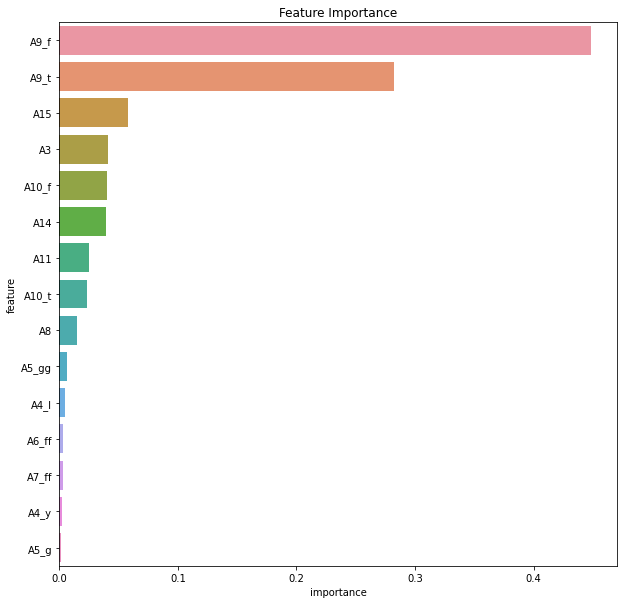

In [27]:
plot_feature_importance(feature_names, feature_importances)

# Evaluate Model Performance

In [28]:
model = get_credit_approval_model()

In [29]:
ypred = model.predict(x_test)
ypred_proba = model.predict_proba(x_test)
ypred_decision = model.decision_function(x_test)

Sklearn Confusion Matrix format with `label=[1, 0]`

https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

```
            predicted                        
            1       0      
          -----   -----    
       1|   1   |   2       
actual    -----   -----             
       0|   4   |   0
```

In [30]:
def plot_cf_matrix(cf_matrix):
    """
    cf_matrix must be created with labels=[1, 0]
    """
    cf_matrix = np.transpose(cf_matrix)
 
    cf_df = pd.DataFrame(cf_matrix, ['Approved', 'Rejected'], ['Approved', 'Rejected'])

    ax = sns.heatmap(
        cf_df, 
        annot=True,
        cmap='Blues',
        fmt='.0f')

    ax.set_xlabel("Actual", fontsize=14, labelpad=20)
    ax.set_ylabel("Predicted", fontsize=14, labelpad=20)
    ax.set_title("Credit Approval Confusion Matrix", fontsize=16, pad=20)

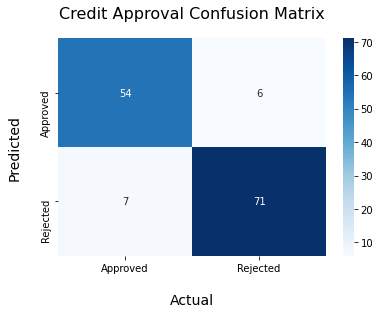

In [31]:
cf_matrix = confusion_matrix(y_test, ypred, labels=[1, 0])
plot_cf_matrix(cf_matrix)

In [32]:
def print_evaluation_summary(y_test, ypred, ypred_proba):
    report = classification_report(y_test, 
                                   ypred, 
                                   labels=[1, 0], 
                                   target_names=['Approved', 'Rejected'])
    auc = roc_auc_score(y_test, ypred_proba[:, 1])
    print(f"Area Under Curve  {auc:.2f}")
    print("-"*55)
    print()
    print(report)

In [33]:
print_evaluation_summary(y_test, ypred, ypred_proba)

Area Under Curve  0.96
-------------------------------------------------------

              precision    recall  f1-score   support

    Approved       0.90      0.89      0.89        61
    Rejected       0.91      0.92      0.92        77

    accuracy                           0.91       138
   macro avg       0.91      0.90      0.90       138
weighted avg       0.91      0.91      0.91       138



In [34]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba[:, 1])
auc = roc_auc_score(y_test, ypred_proba[:, 1])

In [35]:
def plot_roc(fpr, tpr, thresh, auc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC {auc:0.2f})')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='green')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    ax2.vlines(fpr, [0], thresh)
    ax2.set_title("Classification Threshold")    
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("Threshold")

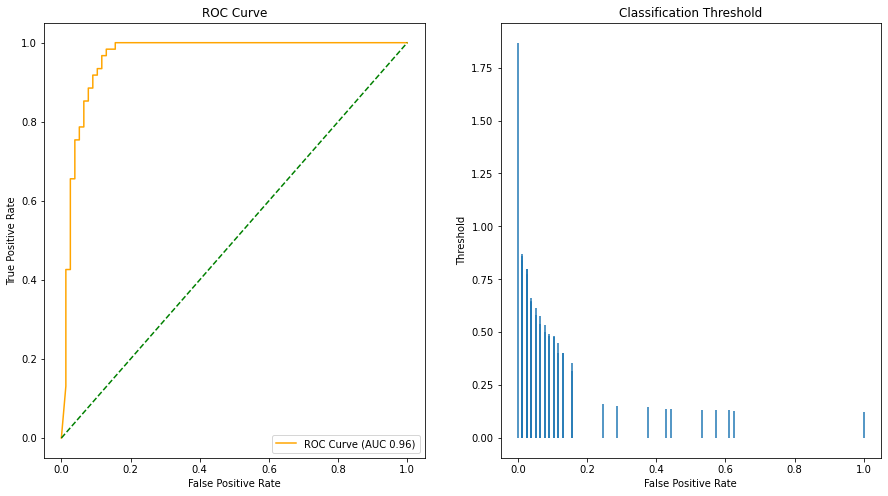

In [36]:
plot_roc(fpr, tpr, thresholds, auc)